<a href="https://colab.research.google.com/github/jabazan/VentasCompiladas/blob/main/Ventas_Compiladas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install sktime
!pip install gspread oauth2client gspread_dataframe
!pip install gspread pandas-gbq


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.0/24.0 MB 18.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 kB 7.8 MB/s eta 0:00:00


In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline


# Use 3 decimal places in output display
pd.set_option("display.precision", 2)

# Don't wrap repr(DataFrame) across additional lines
pd.set_option("display.expand_frame_repr", False)

# Set max rows displayed in output to 25
pd.set_option("display.max_rows", 25)

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import matplotlib.pyplot as plt

ruta="/content/drive/MyDrive/2. Profesional/0. Empresas/7. Trigal/2. PC-Arriba/TRIGAL/"

carpetas = os.listdir(ruta)
prefix = "A"
directorios_ano = [f for f in os.listdir(ruta) if f.startswith(prefix) and os.path.isdir(os.path.join(ruta, f))]
directorios_vtas = [f for f in directorios_ano if int(f[-4:])>2020]
archivos_xlsx = [f for f in carpetas if f.endswith(".xlsx")]
archivos_vtas = [f for f in carpetas if f.startswith("VENTAS")]

df = pd.DataFrame()

for directorio in directorios_vtas:
    path = r"/content/drive/MyDrive/2. Profesional/0. Empresas/7. Trigal/2. PC-Arriba/TRIGAL/"+directorio+"/"
    files = os.listdir(path)
    files_xlsx = [f for f in files if f[-4:] == 'xlsx']
    files_vtas = [f for f in files_xlsx if f[0:4] == 'VENT']

    for f in files_vtas:
        data = pd.read_excel(path+f, 'Hoja1')
        df = pd.concat([df, pd.DataFrame(data)])
df.tail()
df = df.dropna(how = 'all')
df.loc[:,'FECHA'] = pd.to_datetime(df['FECHA'], errors='coerce')
df= df.dropna(subset=['FECHA'])



df= df.drop(columns=['Unnamed: 11','Unnamed: 12','Unnamed: 13','Unnamed: 14'])
numeric_cols = ['DORREGO', 'PASO DE LOS ANDES','REPARTO', 'GODOY CRUZ', 'ESPEJO','9 DE JULIO', 'ESPAÑA', 'MERCADO', 'LA BARRACA', 'COLON', 'LEGUIZAMON']
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')

df= df.fillna(0)

df.set_index('FECHA', inplace=True)
df.sort_index(inplace = True)

df.tail(30)
#df.to_csv('ventas_consolidadas.csv')
#df.to_excel('/content/drive/MyDrive/2. Profesional/0. Empresas/7. Trigal/Documentos Alejandro/Estadisticas/informe_evolucion.xlsx')



,DORREGO,PASO DE LOS ANDES,REPARTO,GODOY CRUZ,ESPEJO,9 DE JULIO,ESPAÑA,MERCADO,LA BARRACA,COLON,LEGUIZAMON
FECHA,,,,,,,,,,,
2024-07-02,294980.0,141550.0,27000.0,468330.0,698270.0,216860.0,216100.0,284100.0,0.0,531640.0,229360.0
2024-07-03,252400.0,150200.0,14900.0,420950.0,863950.0,239450.0,309750.0,227500.0,0.0,523780.0,171950.0
2024-07-04,355040.0,177545.0,20250.0,699300.0,836610.0,306300.0,239100.0,335410.0,0.0,691000.0,301600.0
2024-07-05,346200.0,270740.0,70000.0,537340.0,800080.0,352320.0,285500.0,209300.0,0.0,546500.0,301630.0
2024-07-06,436230.0,246800.0,0.0,587930.0,550000.0,328450.0,328600.0,355600.0,0.0,415150.0,334610.0
...,...,...,...,...,...,...,...,...,...,...,...
2024-07-27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2024-07-28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2024-07-29,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
import gspread
import csv
from oauth2client.service_account import ServiceAccountCredentials

# Transpongo la matriz
df_melted = df.reset_index().melt(id_vars='FECHA', var_name='Sucursal', value_name='Venta')


#Elimino lo NaN
df_melted = df_melted.dropna()

#Elimino valores que no son fechas (TOTAL , etc)
#df_melted['FECHA'] = pd.to_datetime(df_melted['FECHA'], errors='coerce')
#df_melted = df_melted.dropna(subset=['FECHA'])

#Elimino Sucursal 'Unnamed'
df_melted = df_melted[~df_melted.Sucursal.str.contains("Unnamed")]

#Elimino valores muy altos
df_melted = df_melted[df_melted['Venta']<600000000]

"""#Agrego Año, Mes y Día y dia de la semana
df_melted['Ano']=df_melted['FECHA'].dt.year
df_melted['Mes']=df_melted['FECHA'].dt.month
df_melted['Semana']=df_melted['FECHA'].dt.isocalendar().week
df_melted['Dia']=df_melted['FECHA'].dt.day
df_melted['DiaSem']=df_melted['FECHA'].dt.day_name()
"""
#Ordeno por fecha
df_melted.sort_values(by=['FECHA'], inplace=True)

#Exporto a CSV
#df_melted.to_csv('/content/drive/MyDrive/2. Profesional/0. Empresas/7. Trigal/Documentos Alejandro/Estadisticas/df_melted.csv', decimal=',', sep=';')
#print(df_melted)

df.to_excel('/content/drive/MyDrive/2. Profesional/0. Empresas/7. Trigal/Documentos Alejandro/Estadisticas/df_melted.xlsx')


#Definir el alcance (scope)
scope = ["https://spreadsheets.google.com/feeds",
         "https://www.googleapis.com/auth/spreadsheets",
         "https://www.googleapis.com/auth/drive.file",
         "https://www.googleapis.com/auth/drive"]

# Autenticar con las credenciales
creds = ServiceAccountCredentials.from_json_keyfile_name("/content/drive/MyDrive/2. Profesional/Keys/citric-passage-305015-ac116c288e4b.json", scope)
client = gspread.authorize(creds)
spreadsheet_id = "1PxqGBcS80g4fbTgv7ZGQM7dnigpHUHYQlpqrJpqUmlA"  # Please put your Spreadsheet ID.
sheet_name = "df_melted"  # Please put the sheet ID of the sheet you want to use.

# Convert the DataFrame to a list of lists for gspread
df_melted['FECHA'] = df_melted['FECHA'].dt.strftime('%Y-%m-%d')
values = df_melted.values.tolist()

# Intenta actualizar la hoja de cálculo
try:
    spreadsheet = client.open("df_melted")  # Replace with the actual name
    worksheet = spreadsheet.worksheet(sheet_name)
    worksheet.update(values)
    print("La hoja de cálculo se actualizó correctamente.")
except gspread.exceptions.SpreadsheetNotFound:
    print("No se pudo encontrar la hoja de cálculo. Verifica el ID o el nombre.")
except gspread.exceptions.APIError as e:
    print(f"Error al actualizar la hoja de cálculo: {e}")


"""
resultado = pd.pivot_table(df_melted,
index=['Sucursal', 'Ano'],
columns=['Mes'],
values=['Venta'],
fill_value=0,
aggfunc={'Venta': [sum]},
)
resultado.to_excel('/content/drive/MyDrive/2. Profesional/0. Empresas/7. Trigal/Documentos Alejandro/Estadisticas/informe_evolucion.xlsx')

print(resultado)
"""

La hoja de cálculo se actualizó correctamente.


"\nresultado = pd.pivot_table(df_melted,\nindex=['Sucursal', 'Ano'],\ncolumns=['Mes'],\nvalues=['Venta'],\nfill_value=0,\naggfunc={'Venta': [sum]},\n)\nresultado.to_excel('/content/drive/MyDrive/2. Profesional/0. Empresas/7. Trigal/Documentos Alejandro/Estadisticas/informe_evolucion.xlsx')\n\nprint(resultado)\n"

Los datos están en un formato compatible con sktime.
Absolute FH: ForecastingHorizon(['2024-05-17', '2024-05-18', '2024-05-19', '2024-05-20',
               '2024-05-21', '2024-05-22', '2024-05-23', '2024-05-24',
               '2024-05-25', '2024-05-26', '2024-05-27', '2024-05-28',
               '2024-05-29', '2024-05-30', '2024-05-31', '2024-06-01',
               '2024-06-02', '2024-06-03', '2024-06-04', '2024-06-05',
               '2024-06-06', '2024-06-07', '2024-06-08', '2024-06-09',
               '2024-06-10', '2024-06-11', '2024-06-12', '2024-06-13',
               '2024-06-14', '2024-06-15', '2024-06-16', '2024-06-17',
               '2024-06-18', '2024-06-19', '2024-06-20', '2024-06-21',
               '2024-06-22', '2024-06-23', '2024-06-24', '2024-06-25',
               '2024-06-26', '2024-06-27', '2024-06-28', '2024-06-29',
               '2024-06-30', '2024-07-01', '2024-07-02', '2024-07-03',
               '2024-07-04', '2024-07-05', '2024-07-06', '2024-07-07',
      

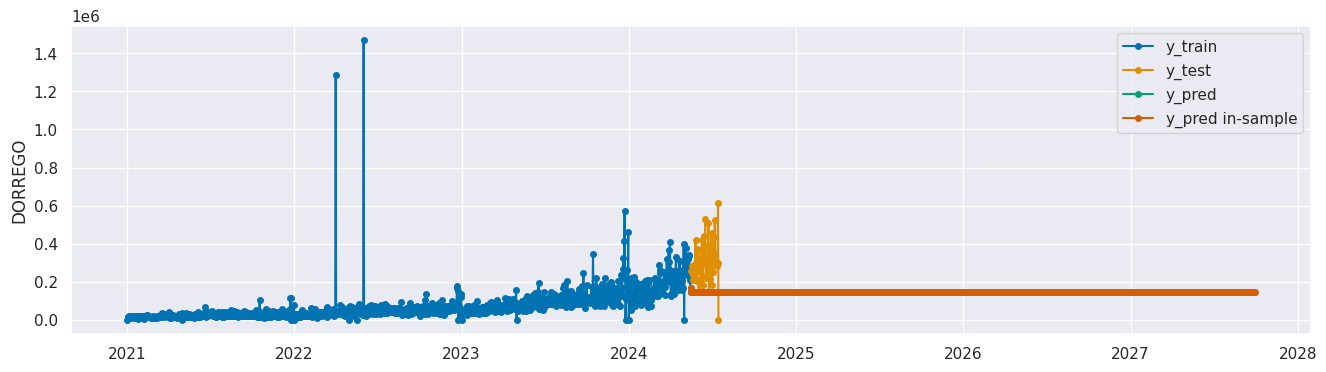

In [ ]:
import pandas as pd
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.base import ForecastingHorizon
from sktime.datatypes import check_raise
import datetime
from sktime.utils.plotting import plot_series
import seaborn as sns

sns.set(rc={'figure.figsize':(12,6)})

# Verifica el formato del DataFrame
try:
    check_raise(df, 'pd.DataFrame')
    print("Los datos están en un formato compatible con sktime.")
except TypeError as e:
    print(f"Error de formato: {e}")

# Filtra los datos para eliminar las fechas mayores a hoy
today = datetime.datetime.today()
df = df[df.index <= today]

# Verifica y maneja las etiquetas duplicadas en el índice
if df.index.duplicated().any():
    df = df[~df.index.duplicated(keep='first')]

# Extrae la serie temporal
y = df['DORREGO'].asfreq('D')

# Divide los datos en entrenamiento y prueba
y_train, y_test = temporal_train_test_split(y, test_size=60)

# Inicializa y ajusta el modelo de pronóstico ingenuo
forecaster = NaiveForecaster(strategy="last")
forecaster.fit(y_train)

# Define el horizonte de predicción usando el índice de y_test
fh_abs = ForecastingHorizon(y_test.index, is_relative=False)
print(f"Absolute FH: {fh_abs}")

# Realiza una predicción para el horizonte de predicción
y_pred_abs = forecaster.predict(fh=fh_abs)

# Define el horizonte de predicción relativo al último punto de y_train
cutoff = y_train.index[-30]
fh_rel = fh_abs.to_relative(cutoff)
print(f"\nRelative FH ahead: {list(fh_rel)}")

# Realiza una predicción relativa
y_pred_rel = forecaster.predict(fh=fh_rel)

# Predicción dentro de la muestra (usando índices relativos)
fh_rel_insample = ForecastingHorizon(range(len(y_train)), is_relative=True)
y_pred_rel_insample = forecaster.predict(fh=fh_rel_insample)


# Grafica los resultados
plot_series(y_train, y_test, y_pred_abs, y_pred_rel_insample, labels=["y_train", "y_test", "y_pred", "y_pred in-sample"])

print(y_pred_abs)

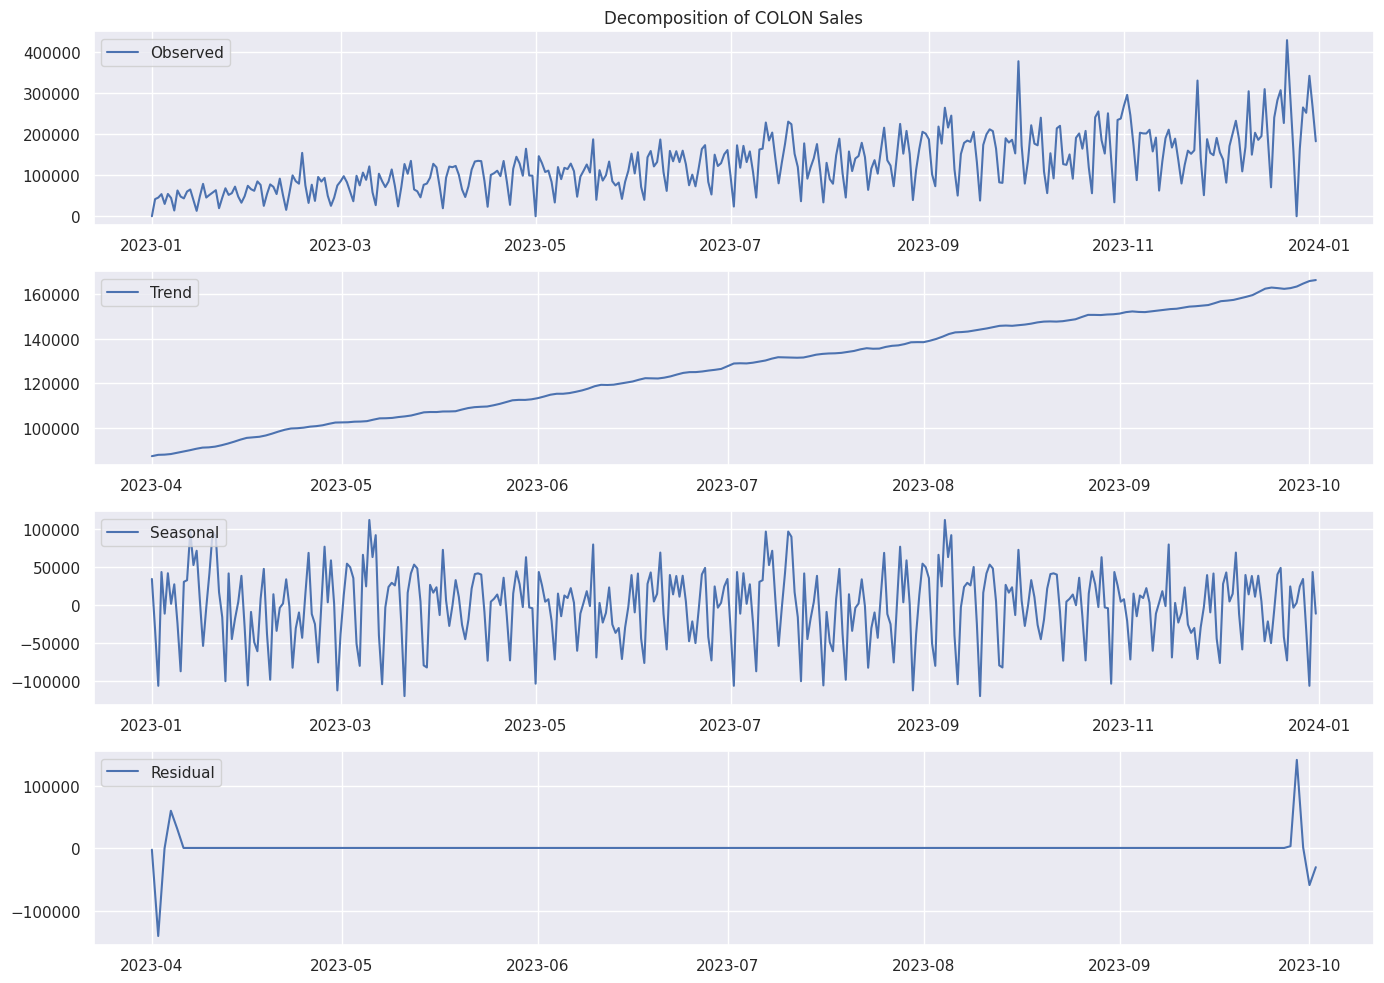

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

start_date = '2023-01-01'
end_date = '2023-12-31'

df2023 = df.loc[start_date:end_date]

#print(df2023)

# Decompose the time series for each branch
decomposition_results = {}
for column in df2023.columns:
    decomposition = seasonal_decompose(df2023[column], model='additive', period=180)
    decomposition_results[column] = decomposition

# Plot the decomposed components for one of the branches as an example
branch = 'COLON'
result = decomposition_results[branch]

plt.figure(figsize=(14, 10))
plt.subplot(411)
plt.plot(result.observed, label='Observed')
plt.title(f'Decomposition of {branch} Sales')
plt.legend(loc='upper left')

plt.subplot(412)
plt.plot(result.trend, label='Trend')
plt.legend(loc='upper left')

plt.subplot(413)
plt.plot(result.seasonal, label='Seasonal')
plt.legend(loc='upper left')

plt.subplot(414)
plt.plot(result.resid, label='Residual')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()
